# STK player bot detector with SageMaker Linear Regression - Logistic Regression¶


#### Install packages

In [13]:
%%bash 
home=`pwd`
. $home/env
pip3 install mysql-connector-python

bash: line 2: /home/ec2-user/SageMaker/amazon-aurora-call-to-amazon-sagemaker-sample/stk-sample/env-build/sagemaker/env: No such file or directory
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [14]:
import sagemaker
execution_role = sagemaker.get_execution_role()
print(execution_role)

arn:aws:iam::163538056407:role/service-role/AmazonSageMaker-ExecutionRole-20200913T212219


### Get training and test data from Aurora DB

In [73]:
%%time

import json
import boto3
import csv
import mysql.connector
import sys
import os
import configparser

config = configparser.ConfigParser()

config.read('rds.ini')

ENDPOINT=config['default']['ENDPOINT']
USR=config['default']['USR']
PASWD=config['default']['PASWD']
REGION=config['default']['REGION']
DBNAME=config['default']['DBNAME']

client = boto3.client('rds')

CPU times: user 1.01 ms, sys: 5.8 ms, total: 6.81 ms
Wall time: 6.15 ms


Getting the right size of the grouping

In [106]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
    
  cur.execute("""select id,c_v,vel,vel_l,vel_r,class from v_actions_m_value_velocity where class=0 and party_size=2""")
  human_vel_m_value_list=cur.fetchall()
    
  cur.execute("""select id,c_v,vel,vel_l,vel_r,class from v_actions_m_value_velocity where class=1 and party_size=2""")
  bot_vel_m_value_list=cur.fetchall()  

  cur.execute("""select id,accel,accel_l,accel_r,class from v_actions_m_value_accel where class=0 and party_size=2""")
  human_accel_m_value_list=cur.fetchall()
    
  cur.execute("""select id,accel,accel_l,accel_r,class from v_actions_m_value_accel where class=1 and party_size=2""")
  bot_accel_m_value_list=cur.fetchall()
    
  cur.execute("""select id,c_t,vel,class from v_actions_ticks_velocity where class=0""")
  human_vel_ticks_list=cur.fetchall()
    
  cur.execute("""select id,c_t,vel,class from v_actions_ticks_velocity where class=1""")
  bot_vel_ticks_list=cur.fetchall()
    
  cur.execute("""select id,accel,class from v_actions_ticks_accel where class=0""")
  human_accel_ticks_list=cur.fetchall()
    
  cur.execute("""select id,accel,class from v_actions_ticks_accel where class=1""")
  bot_accel_ticks_list=cur.fetchall()
    
except Exception as e:
  print("Database connection failed due to {}".format(e))

CPU times: user 22.3 ms, sys: 11.8 ms, total: 34.1 ms
Wall time: 198 ms


### Investigate and process the data

In [107]:
import pandas as pd

human_vel_m_value=pd.DataFrame(human_vel_m_value_list)
bot_vel_m_value=pd.DataFrame(bot_vel_m_value_list)

human_vel_m_value.rename(columns={0:'id',
                            1:'c_v',
                            2:'vel',
                            3:'vel_l',
                            4:'vel_r',
                            5:'class'
                           }, 
                 inplace=True)
bot_vel_m_value.rename(columns={0:'id',
                            1:'c_v',
                            2:'vel',
                            3:'vel_l',
                            4:'vel_r',
                            5:'class'
                           }, 
                 inplace=True)


human_accel_m_value=pd.DataFrame(human_accel_m_value_list)
bot_accel_m_value=pd.DataFrame(bot_accel_m_value_list)

human_accel_m_value.rename(columns={0:'id',
                            1:'accel',
                            2:'accel_l',
                            3:'accel_r',
                            4:'class'
                           }, 
                 inplace=True)
bot_accel_m_value.rename(columns={0:'id',
                            1:'accel',
                            2:'accel_l',
                            3:'accel_r',
                            4:'class'
                           }, 
                 inplace=True)


human_vel_ticks=pd.DataFrame(human_vel_ticks_list)
bot_vel_ticks=pd.DataFrame(bot_vel_ticks_list)

human_vel_ticks.rename(columns={0:'id',
                            1:'c_t',
                            2:'vel',
                            3:'class'
                           }, 
                 inplace=True)
bot_vel_ticks.rename(columns={0:'id',
                            1:'c_t',
                            2:'vel',
                            3:'class'
                           }, 
                 inplace=True)


human_accel_ticks=pd.DataFrame(human_accel_ticks_list)
bot_accel_ticks=pd.DataFrame(bot_accel_ticks_list)

human_accel_ticks.rename(columns={0:'id',
                            1:'accel',
                            2:'class'
                           }, 
                 inplace=True)
bot_accel_ticks.rename(columns={0:'id',
                            1:'accel',
                            2:'class'
                           }, 
                 inplace=True)

### Let's look for interesting data patterns
#### first look at player ticks 

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

id       1372
c_t      1372
vel      1372
class    1372
dtype: int64


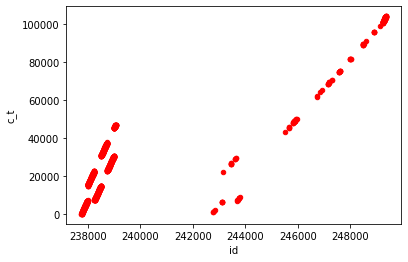

In [109]:
print(bot_vel_ticks.count())
bot_vel_ticks.plot(kind='scatter',x='id',y='c_t',color='red')
plt.show()

id       3174
c_t      3174
vel      3174
class    3174
dtype: int64


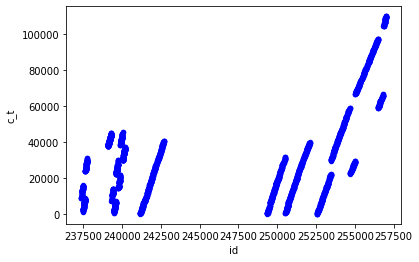

In [110]:
print(human_vel_ticks.count())
human_vel_ticks.plot(kind='scatter',x='id',y='c_t',color='blue')
plt.show()

id       1250
accel    1250
class    1250
dtype: int64


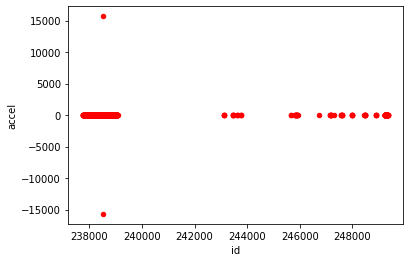

In [111]:
print(bot_accel_ticks.count())
bot_accel_ticks.plot(kind='scatter',x='id',y='accel',color='red')
plt.show()

id       1464
accel    1464
class    1464
dtype: int64


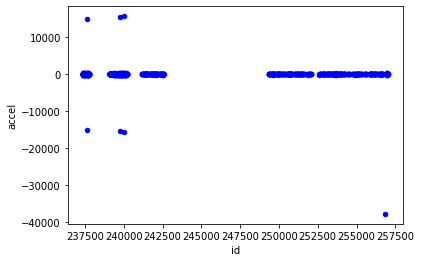

In [112]:
print(human_accel_ticks.count())
human_accel_ticks.plot(kind='scatter',x='id',y='accel',color='blue')
plt.show()

We can see different patterns for `m_ticks` in bot and human. But `m_ticks` average velocity and acceleration seems to be similar so we need to look for more patterns. Lets look at `m_values` of those player ticks. Specifically for `actions=0 or 1`

id       2512
c_v      2512
vel      2512
vel_l    2512
vel_r    2512
class    2512
dtype: int64
Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')


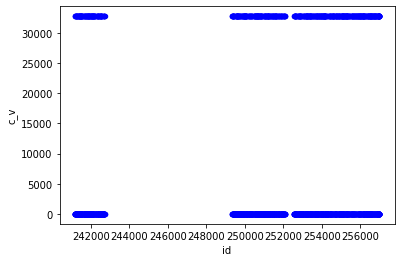

In [113]:
print(human_vel_m_value.count())
print(human_vel_m_value.columns)
human_vel_m_value.plot(kind='scatter',x='id',y='c_v',color='blue')
plt.show()

id       198
c_v      198
vel      198
vel_l    198
vel_r    198
class    198
dtype: int64
Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')


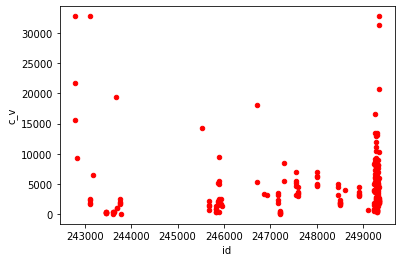

In [114]:
print(bot_vel_m_value.count())
print(bot_vel_m_value.columns)
bot_vel_m_value.plot(kind='scatter',x='id',y='c_v',color='red')
plt.show()

We can see the bot `m_value` distrubition is different than human. Lets see the average velocity changes. 

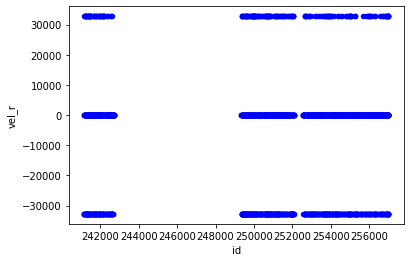

Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')

In [115]:
human_vel_m_value.plot(kind='scatter',x='id',y='vel_r',color='blue')
plt.show()
human_vel_m_value.columns

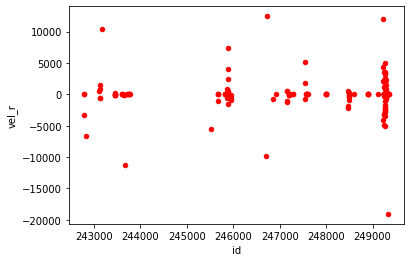

Index(['id', 'c_v', 'vel', 'vel_l', 'vel_r', 'class'], dtype='object')

In [116]:
bot_vel_m_value.plot(kind='scatter',x='id',y='vel_r',color='red')
plt.show()
bot_vel_m_value.columns

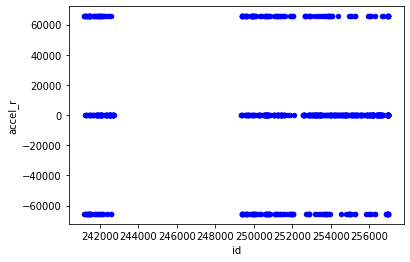

Index(['id', 'accel', 'accel_l', 'accel_r', 'class'], dtype='object')

In [117]:
human_accel_m_value.plot(kind='scatter',x='id',y='accel_r',color='blue')
plt.show()
human_accel_m_value.columns

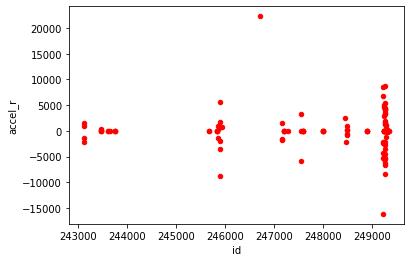

Index(['id', 'accel', 'accel_l', 'accel_r', 'class'], dtype='object')

In [129]:
bot_accel_m_value.plot(kind='scatter',x='id',y='accel_r',color='red')
plt.show()
bot_accel_m_value.columns

Alright, enough with the graphs, we noticed `m_value` and its `accel` as well as `m_value_l` and `m_value_r` and its `accel_l`, `accel_r` behave diffrently for `party_size=2`. lets build a data structure that includes these fields. 

In [190]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
    
  cur.execute("""select m_action,
                  c_v value,c_vel velocity,accel,
                  c_v_l value_l,c_vel_l velocity_l,accel_l,
                  c_v_r value_r,c_vel_r velocity_r,accel_r,
                  class
                 from v_actions_m_value_accel where party_size=2""")
  actions_m_value_accel_list=cur.fetchall()
    
except Exception as e:
  print("Database connection failed due to {}".format(e))


actions_m_value_accel=pd.DataFrame(actions_m_value_accel_list)

actions_m_value_accel.rename(columns={0:'m_action',
                            1:'value',
                            2:'velocity',
                            3:'accel',
                            4:'value_l',
                            5:'velocity_l',
                            6:'accel_l',
                            7:'value_r',
                            8:'velocity_r',
                            9:'accel_r',
                           10:'class'
                           }, 
                 inplace=True)
actions_m_value_accel.groupby('m_action').size()

CPU times: user 26.6 ms, sys: 0 ns, total: 26.6 ms
Wall time: 170 ms


m_action
0.0    678
1.0    499
2.0     94
3.0     20
4.0      1
7.0      4
8.0      2
dtype: int64

In [237]:
actions_m_value_accel.m_action[46]

3.0

### Encoding the categorical feature m_action 

In [242]:
from numpy import argmax
from numpy import array
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
values=array(actions_m_value_accel.m_action)
print("values")
print(values)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("integer_encoded")
print(integer_encoded[46])
print(integer_encoded[26])
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("onehot_encoded")
print(onehot_encoded[46])
print(onehot_encoded[26])
#actions_m_value_accel["m_action_onehot_encoded"]=onehot_encoded

values
[1. 1. 1. ... 0. 0. 0.]
integer_encoded
3
0
onehot_encoded
[0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]


## Build few models - full data, m_ticks, and m_value

## ticks data - (ticks,action,value,value_l,value_r) - prepare the data 

In [393]:
ticks_actions = pd.DataFrame(action_list)
ticks_actions.rename(columns={0:'sessionid',
                        1:'id',
                        2:'m_ticks',
                        3:'m_kart_id',
                        4:'m_action',
                        5:'m_value',
                        6:'m_value_l',
                        7:'m_value_r',
                        8:'class'
                     }, 
                 inplace=True)
print(ticks_actions.columns)
print(ticks_actions.count())

Index(['sessionid', 'id', 'm_ticks', 'm_kart_id', 'm_action', 'm_value',
       'm_value_l', 'm_value_r', 'class'],
      dtype='object')
sessionid    171128
id           171128
m_ticks      171128
m_kart_id    171128
m_action     171128
m_value      171128
m_value_l    171128
m_value_r    171128
class        171128
dtype: int64


In [394]:
ticks_actions=ticks_actions.drop('id',axis=1)
ticks_actions=ticks_actions.drop('m_action',axis=1)
ticks_actions=ticks_actions.drop('m_value',axis=1)
ticks_actions=ticks_actions.drop('m_value_l',axis=1)
ticks_actions=ticks_actions.drop('m_value_r',axis=1)

In [395]:
ticks_actions.head()
print(ticks_actions.groupby('class',axis=0).size())

class
0    94740
1    76388
dtype: int64


Populate a dictionary with series of `m_ticks` with the same `session_id`, `m_kart_id` and `class`. the output number should indicate the same size of the data in Aurora.

In [396]:
player_session_dict = {}
i=0

for index, row in ticks_actions.iterrows():
  i=i+1
  play_action_val=row['m_ticks']
  play_action_key=row['sessionid'],row['m_kart_id'],row['class']
  if(player_session_dict.get(play_action_key)):
    session_list=player_session_dict[play_action_key]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list 
  else:
    session_list=[]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list
print(i)

171128


In [400]:
import numpy as np
session_len=10
#a line in the array includes m_ticks plus the classification 
size_of_arr_line=session_len*1+1
sessions_array = np.zeros((12971,size_of_arr_line), dtype=float, order='C')
k=0
j=0
i=0
sum_of_actions=0
for key in player_session_dict:
  raw_session=player_session_dict[key]
  #break the session into equal parts session_len actions long
  sessions_list=[raw_session[i:i + session_len] for i in range(0, len(raw_session), session_len)] 
  #every session has session_len action set
  for session in sessions_list:
    #including only the full sessions with excatly 25 actions
    if(len(session)==session_len):
      k=k+1
      if(key[2]==0):
        j=j+1
      else:
        i=i+1
      new_row=[]
      for action in session:
        new_row.append(action)
      #add class field to the last column 
      new_row.append(key[2])
      sessions_array[k]=np.asarray(new_row)
       
print('number of 0 keys in full session {}'.format(j))
print('number of 1 keys in full session {}'.format(i))
print('the size of the sessions_array is {}'.format(k))

number of 0 keys in full session 7707
number of 1 keys in full session 5263
the size of the sessions_array is 12970


In [401]:
df=pd.DataFrame(sessions_array) 
df

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21768.0,21794.0,21830.0,21891.0,21936.0,21980.0,22101.0,22141.0,22295.0,22313.0,0.0
2,22357.0,22406.0,22449.0,22482.0,22574.0,22583.0,22662.0,22716.0,22781.0,22795.0,0.0
3,23053.0,23074.0,23446.0,23465.0,23650.0,23666.0,23723.0,23862.0,23864.0,23885.0,0.0
4,23896.0,23914.0,23922.0,23956.0,23999.0,24037.0,24105.0,24130.0,24156.0,24195.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12966,13608.0,13697.0,13851.0,13916.0,13923.0,13934.0,13937.0,13969.0,14029.0,14102.0,0.0
12967,14155.0,14250.0,14287.0,14445.0,14475.0,14476.0,14498.0,14555.0,14586.0,14706.0,0.0
12968,14755.0,14767.0,14784.0,15022.0,15046.0,15102.0,15132.0,15178.0,15220.0,15248.0,0.0
12969,15295.0,15326.0,15497.0,15576.0,16436.0,16482.0,16527.0,16562.0,16615.0,16814.0,0.0


In [402]:
print(df.groupby(session_len,axis=0).size())
df.head(1000)

10
0.0    7708
1.0    5263
dtype: int64


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21768.0,21794.0,21830.0,21891.0,21936.0,21980.0,22101.0,22141.0,22295.0,22313.0,0.0
2,22357.0,22406.0,22449.0,22482.0,22574.0,22583.0,22662.0,22716.0,22781.0,22795.0,0.0
3,23053.0,23074.0,23446.0,23465.0,23650.0,23666.0,23723.0,23862.0,23864.0,23885.0,0.0
4,23896.0,23914.0,23922.0,23956.0,23999.0,24037.0,24105.0,24130.0,24156.0,24195.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
995,23297.0,23298.0,23299.0,23300.0,23326.0,23327.0,23329.0,23330.0,23331.0,23332.0,0.0
996,23249.0,23251.0,23252.0,23253.0,23255.0,23256.0,23256.0,23257.0,23258.0,23260.0,0.0
997,23261.0,23262.0,23263.0,23284.0,23285.0,23286.0,23287.0,23299.0,23300.0,23301.0,0.0
998,23302.0,23303.0,23304.0,23306.0,23316.0,23317.0,23318.0,23320.0,23321.0,23322.0,0.0


In [403]:
feature_columns = df.columns[:-1]
label_column = df.columns[-1]

print('feature_columns={}'.format(feature_columns))
print('label_column={}'.format(label_column))

features = df[feature_columns].values.astype('float32')
labels = (df[label_column].values).astype('float32')
print(features[3])
labels[3]

feature_columns=RangeIndex(start=0, stop=10, step=1)
label_column=10
[23053. 23074. 23446. 23465. 23650. 23666. 23723. 23862. 23864. 23885.]


0.0

In [404]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

In [405]:
import boto3
import os
import sagemaker

session = sagemaker.Session()
bucket = 'stk-events'

prefix = 'bot-detect-ticks-model'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://stk-events/bot-detect-ticks-model/train/recordio-pb-data
Training artifacts will be uploaded to: s3://stk-events/bot-detect-ticks-model/output


In [406]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data},wait=True)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-11-03 16:39:15 Starting - Starting the training job...
2020-11-03 16:39:20 Starting - Launching requested ML instances......
2020-11-03 16:40:29 Starting - Preparing the instances for training......
2020-11-03 16:41:43 Downloading - Downloading input data...
2020-11-03 16:42:04 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 16:42:28 INFO 140649179998016] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'in

In [ ]:
#delete old endpoint
sagemaker.Session().delete_endpoint("arn:aws:sagemaker:us-west-2:163538056407:endpoint/stk-bot-detect-ticks")

In [331]:
from sagemaker.predictor import csv_serializer, json_deserializer


linear_predictor = linear.deploy(initial_instance_count=1,
                                 endpoint_name='stk-bot-detect-ticks',
                                 instance_type='ml.c4.large')
# Specify input and output formats.
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
print('Endpoint name: {}'.format(linear_predictor.endpoint))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!Endpoint name: stk-bot-detect-ticks


In [332]:
%%time
import pandas as pd

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
        select group_concat(concat(m_ticks)) as sample
                from (
                        select concat(id,"-",m_kart_id) id, m_ticks
                        from (
                                select id,m_kart_id,m_ticks
                                from (
                                        select id,m_kart_id,m_ticks
                                        from actions order by id desc limit 70) t1 order by m_kart_id limit 10) t2) t3; 
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
sample=''.join(sample_list[0])


CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 88.5 ms


'84351,83390,84010,83111,84537,83700,84320,83359,84847,83979'

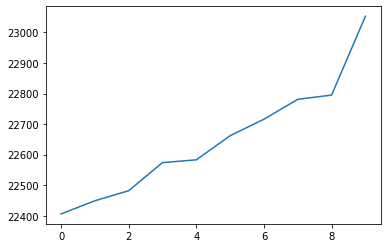

In [368]:
import pandas as pd
#sample='31,31,62,93,124,155,186,217,248,279'
#sample='124,155,186,217,248,279,310,341,372,403'
#sample='310,341,372,403,434,465,496,527,558,589'
#linear_predictor.predict(sample)
sample_df=pd.Series([22406,22449,22482,22574,22583,22662,22716,22781,22795,23053])
sample_df.plot.line()
#linear_predictor.predict(sample_df.tolist())

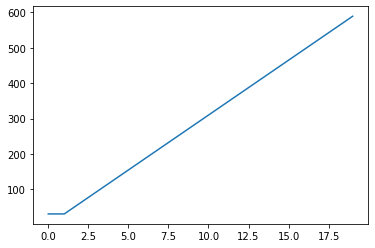

In [3]:
sample_df=pd.Series([31,31,62,93,124,155,186,217,248,279,310,341,372,403,434,465,496,527,558,589])
sample_df.plot.line()

In [ ]:
sample='310,341,372,403,434,465,496,527,558,589'
sample='589,558,527,496,465,434,403,372,341,310'
sample='23053,22795,22781,22716,22662,22583,22574,22482,22449,22406'
sample='589,558,527,496,465,434,403,372,341,310'
linear_predictor.predict(sample)

In [ ]:
%%time
import pandas as pd
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.accept = 'application/json'
linear_predictor.deserializer = json_deserializer

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
            select ticks_1,ticks_2,ticks_3,ticks_4,ticks_5,ticks_6,ticks_7,ticks_8,ticks_9,ticks_10 from ticks_session_sample;
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))

for sample in sample_list:
  results=linear_predictor.predict(sample)
  print('{} predict {}'.format(sample,results))

## Full data - (ticks,action,value,value_l,value_r) - prepare the data 

In [180]:
actions = pd.DataFrame(action_list)
actions.rename(columns={0:'sessionid',
                        1:'id',
                        2:'m_ticks',
                        3:'m_kart_id',
                        4:'m_action',
                        5:'m_value',
                        6:'m_value_l',
                        7:'m_value_r',
                        8:'class'
                     }, 
                 inplace=True)
print(actions.columns)
print(actions.count())

Index(['sessionid', 'id', 'm_ticks', 'm_kart_id', 'm_action', 'm_value',
       'm_value_l', 'm_value_r', 'class'],
      dtype='object')
sessionid    76203
id           76203
m_ticks      76203
m_kart_id    76203
m_action     76203
m_value      76203
m_value_l    76203
m_value_r    76203
class        76203
dtype: int64


We used `id` for sorting the session actions but now we dont need it anymore.

In [181]:
full_actions=actions.drop('id',axis=1)

Checking the amount of data we lose in aggreagtion. The session length is 25 so we are going loose all the session that are smaller than 25

In [185]:
print(full_actions.groupby(['sessionid'],axis=0).size())
sum=0
for i in full_actions.groupby(['sessionid'],axis=0).size():
  #print(i,end='####')
  if(i>session_len):
    sum=sum+i
print(sum)
full_actions.count()

sessionid
0        99
1       100
2       100
3       100
4       100
       ... 
1083    100
1084    100
1085    100
1086    100
1087     87
Length: 769, dtype: int64
76193


sessionid    76203
m_ticks      76203
m_kart_id    76203
m_action     76203
m_value      76203
m_value_l    76203
m_value_r    76203
class        76203
dtype: int64

Checking the size of sessions. Session is an ordered set of actions grouped by the sessiondid, the player kart id and the classification. 

Classification is set as 1 in case of human, and 0 as bot.

The `sum` is the number of remaining data after aggregating on both the kartid and class.

Construct a dictonary based on `sessionid` and action classification `class`

In [186]:
player_session_dict = {}
i=0

for index, row in full_actions.iterrows():
  i=i+1
  play_action_val=row['m_ticks'],row['m_action'],row['m_value'],row['m_value_l'],row['m_value_r']
  play_action_key=row['sessionid'],row['m_kart_id'],row['class']
  if(player_session_dict.get(play_action_key)):
    session_list=player_session_dict[play_action_key]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list 
  else:
    session_list=[]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list
print(i)

76203


Check the session length (number of actions in a session)

In [187]:
sum=0
for key in player_session_dict.keys():
  if (len(player_session_dict[key])>=session_len):
    #print(len(player_session_dict[key]),end = '###')
    sum=sum+len(player_session_dict[key])
print()
print('number of actions pulled from aurora={}'.format(i))
print('number of actions after initial aggregations={}'.format(sum))
len(player_session_dict)


number of actions pulled from aurora=76203
number of actions after initial aggregations=67939


3814

Transpose the dataframe to a new column strucutre that concatenates series of consecutive actions in a fixed size of 25

In [189]:
import numpy as np

#a line in the array is five set of actions plus the classification 
size_of_arr_line=session_len*5+1
sessions_array = np.zeros((5898,size_of_arr_line), dtype=float, order='C')

i=0
sum_of_actions=0
for key in player_session_dict:
  raw_session=player_session_dict[key]
  #break the session into equal parts 25 actions long
  sessions_list=[raw_session[i:i + session_len] for i in range(0, len(raw_session), session_len)]  
  #every session has 25 action set
  for session in sessions_list:
    #including only the full sessions with excatly 25 actions
    if(len(session)==session_len):
      new_row=[]
      for action in session:
        new_row.append(action[0])
        new_row.append(action[1])
        new_row.append(action[2])
        new_row.append(action[3])
        new_row.append(action[4])
      #add class field to the last column 
      new_row.append(key[2])
      sessions_array[i]=np.asarray(new_row)
      i=i+1 
print(i)

5898


In [190]:
df=pd.DataFrame(sessions_array) 

In [191]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,21768.0,0.0,32768.0,0.0,0.0,21794.0,0.0,0.0,32768.0,0.0,...,0.0,32768.0,0.0,0.0,22313.0,0.0,0.0,32768.0,0.0,0.0
1,22357.0,0.0,32768.0,0.0,0.0,22406.0,0.0,0.0,32768.0,0.0,...,7.0,32768.0,0.0,0.0,22795.0,7.0,0.0,0.0,0.0,0.0
2,23053.0,0.0,32768.0,0.0,0.0,23074.0,0.0,0.0,32768.0,0.0,...,4.0,0.0,0.0,-32768.0,23885.0,1.0,0.0,0.0,-32768.0,0.0
3,23896.0,4.0,32768.0,0.0,0.0,23914.0,4.0,0.0,0.0,0.0,...,0.0,32768.0,0.0,0.0,24195.0,0.0,0.0,32768.0,0.0,0.0
4,21777.0,1.0,32768.0,0.0,0.0,21801.0,1.0,0.0,0.0,-32768.0,...,1.0,32768.0,0.0,0.0,22163.0,1.0,0.0,0.0,-32768.0,0.0


In [192]:
print(df.groupby(session_len,axis=0).size())
df.head(1)

10
0.0        17
2.0         1
5.0         1
15.0        1
64.0        1
           ..
75795.0     1
95893.0     1
96643.0     1
96906.0     1
97667.0     1
Length: 5140, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,21768.0,0.0,32768.0,0.0,0.0,21794.0,0.0,0.0,32768.0,0.0,...,0.0,32768.0,0.0,0.0,22313.0,0.0,0.0,32768.0,0.0,0.0


To check if we did not loose data we need to multiple the number by 25

In [194]:
full_actions.groupby(['class'],axis=0).size()

class
0    65618
1    10585
dtype: int64

Check how much data was lost during transformation.

In [700]:
print(120/3817)
print(1186/36632)

0.03143830233167409
0.03237606464293514


In [195]:
print(df.columns)
feature_columns = df.columns[:-1]
label_column = df.columns[-1]

print('feature_columns={}'.format(feature_columns))
print('label_column={}'.format(label_column))

features = df[feature_columns].values.astype('float32')
labels = (df[label_column].values).astype('float32')

RangeIndex(start=0, stop=51, step=1)
feature_columns=RangeIndex(start=0, stop=50, step=1)
label_column=50


### Prepare Data and Upload to S3

In [196]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

Now we upload the data to S3 using boto3.

In [197]:
import boto3
import os
import sagemaker

session = sagemaker.Session()
bucket = 'stk-events'

prefix = 'anticheat-model'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://stk-events/anticheat-model/train/recordio-pb-data
Training artifacts will be uploaded to: s3://stk-events/anticheat-model/output


In [198]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data},wait=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Host Linear Classifier

Now we deploy the estimator to and endpoint.


In [ ]:
#sagemaker.Session().delete_endpoint(linear.endpoint)
from sagemaker.predictor import csv_serializer, json_deserializer

#delete old endpoint
sagemaker.Session().delete_endpoint(linear.endpoint)

linear_predictor = linear.deploy(initial_instance_count=1,
                                 endpoint_name="stk-bot-detector",
                                 instance_type='ml.m4.xlarge')
# Specify input and output formats.
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
print('Endpoint name: {}'.format(linear_predictor.endpoint))

In [664]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.accept = 'application/json'
linear_predictor.deserializer = json_deserializer

### Calling the endpoint

prepare the parameters for the model endpoint call.

This SQL will return a game session actions (25 actions) that we trained the model with

```sql
select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r 
from (
    select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r 
    from actions order by m_kart_id,id limit 25) t;
```

Here is an example result

```
mysql> select * from tmp
    -> ;
+-------+---------+----------+---------+-----------+-----------+
| id    | ticks   |   action |   value |   value_l |   value_r |
+-------+---------+----------+---------+-----------+-----------+
| 0     |      31 |        1 |    4479 |         0 |         0 |
| 1     |      32 |        2 |   32768 |         0 |     -4479 |
| 2     |      62 |        1 |    5423 |         0 |     -4479 |
| 3     |      93 |        1 |    6317 |         0 |     -5423 |
| 4     |     124 |        1 |    5064 |         0 |     -6317 |
| 5     |     155 |        1 |    5729 |         0 |     -5064 |
| 6     |     186 |        1 |    6469 |         0 |     -5729 |
| 7     |     217 |        1 |    6714 |         0 |     -6469 |
| 8     |     248 |        0 |   32768 |         0 |     -6714 |
| 9.    |     279 |        1 |    7953 |     32768 |     -6714 |
| 10    |     310 |        1 |   14415 |     32768 |     -7953 |
| 11    |     341 |        0 |    3698 |     32768 |    -14415 |
| 12    |     372 |        0 |    5492 |      3698 |    -14415 |
| 13    |     403 |        0 |   20817 |      5492 |    -14415 |
| 14    |     434 |        0 |   26290 |     20817 |    -14415 |
| 15.   |     465 |        0 |   24373 |     26290 |    -14415 |
| 16.   |     496 |        0 |   11402 |     24373 |    -14415 |
| 17.   |     527 |        0 |   10370 |     11402 |    -14415 |
| 18.   |     558 |        0 |   12071 |     10370 |    -14415 |
| 19.   |     589 |        0 |   15223 |     12071 |    -14415 |
| 20.   |     620 |        0 |   17070 |     15223 |    -14415 |
| 21.   |     651 |        0 |   19485 |     17070 |    -14415 |
| 22.   |     682 |        0 |   16294 |     19485 |    -14415 |
| 23.   |     713 |        0 |   12267 |     16294 |    -14415 |
| 24.   |     744 |        0 |   10856 |     12267 |    -14415 |
+-------+---------+----------+---------+-----------+-----------+
```

We need to concatenate the 25 results into a single line to send it to the model endpoint.

```
+---------+----------+---------+-----------+-----------+      +---------+---------+--------+----------+----------+
| ticks_0 | action_0 | value_0 | value_l_0 | value_r_0 |..... |ticks_24 |action_24|value_24|value_l_24|value_r_24|
+---------+----------+---------+-----------+-----------+      +---------+---------+--------+----------+----------+
    31         1         4479       0            0                 744      0        10856     12267     -14415
```

```sql
select group_concat(concat(m_ticks,',',m_action,',',m_value,',',m_value_l,',',m_value_r)) as col 
from (select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r  
      from (     
          select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r      
          from actions order by m_kart_id,id limit 25) 
      t) 
t1;
```

In [665]:
%%time
import pandas as pd

modulo_size=224

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
        select group_concat(concat(m_ticks,',',m_action,',',m_value,',',m_value_l,',',m_value_r)) as sample
                from (
                        select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r
                        from (
                                select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                from (
                                        select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                        from actions order by id desc limit 70) t1 order by m_kart_id limit 25) t2) t3; 
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
sample=''.join(sample_list[0])

CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 98.7 ms


In [666]:
sample=''.join(sample_list[0])

In [667]:
sample

'80447,0,0,32768,0,78329,1,0,0,-32768,76364,1,32768,0,0,78647,1,0,0,-32768,76891,0,0,32768,0,79382,1,32768,0,0,77409,4,0,32768,0,79825,1,0,0,-32768,77971,1,32768,0,0,80669,3,0,0,0,78484,1,32768,0,0,76713,1,32768,0,0,79121,1,0,0,-32768,77126,0,32768,0,0,79600,1,32768,0,0,77585,0,32768,0,0,80430,0,32768,0,0,78299,1,32768,0,0,76239,1,0,0,-32768,78622,1,32768,0,0,76875,0,32768,0,0,79270,1,0,0,-32768,77261,0,32768,0,0,79774,1,32768,0,0,77882,1,0,0,-32768'

In [668]:
results = linear_predictor.predict(sample)
print(results)

{'predictions': [{'score': 0.0001962552487384528, 'predicted_label': 0}]}


In [671]:
%%time
import pandas as pd

modulo_size=224

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""
        select group_concat(concat(m_ticks,',',m_action,',',m_value,',',m_value_l,',',m_value_r)) as sample
                from (
                        select concat(id,"-",m_kart_id) id, m_ticks,m_action,m_value,m_value_l,m_value_r
                        from (
                                select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                from (
                                        select id,m_kart_id,m_ticks,m_action,m_value,m_value_l,m_value_r
                                        from actions where class=1 order by id limit 70) t1 order by m_kart_id limit 25) t2) t3; 
              """)
  sample_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
sample=''.join(sample_list[0])
sample

CPU times: user 19.1 ms, sys: 0 ns, total: 19.1 ms
Wall time: 63.7 ms


'62,1,846,0,-672,589,0,32768,32768,-32768,899,0,30620,19736,-1848,279,0,765,0,-102,651,7,32768,32768,-5391,31,1,672,0,0,837,0,3445,11325,-1848,217,1,69,0,-287,1085,0,32768,18005,-3301,434,0,32768,32768,-20774,775,0,11325,11227,-9552,155,1,456,0,-282,31,2,32768,0,-672,527,1,32768,32768,-29192,1023,1,3301,16818,-1848,372,1,9534,32768,-102,713,1,9552,32768,-19031,93,1,209,0,-846,930,0,32768,30620,-1848,310,0,508,765,-102,868,0,19736,3445,-1848,248,1,102,0,-69,806,1,1848,11325,-9552,186,1,287,0,-456,682,1,19031,32768,-5391'

In [672]:
results = linear_predictor.predict(sample)
print(results)

{'predictions': [{'score': 0.15919774770736694, 'predicted_label': 0}]}


### Clean up


We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run linear_predictor.delete_endpoint()